In [17]:
import easyocr
reader = easyocr.Reader(['en'])

In [18]:
import pandas as pd

In [19]:
result = reader.readtext('Capturar.PNG')


In [75]:
def create_ocr_metadata(ocr_output: list) -> pd.DataFrame:
    dataset = []
    for row in ocr_output:
        text = row[1]
        box = row[0]
        x_start = box[0][0]
        y_start = box[0][1]
        y_end = box[1][1]
        x = x_start
        text_size = len(text)
        y = ((y_end - y_start) / 2) + y_end
        dataset.append({
            'text': text,
            'x': x, 
            'y': y, 
            'text_size': text_size
        })
    tbl = pd.DataFrame(dataset).astype({'text': 'string'})
    max_y = max(tbl['y'])

    tbl['y'] = tbl['y'].apply(lambda y: max_y - y)

    return tbl

def calculate_axis_frequency(
    dataset: pd.DataFrame, 
    axis_source_name: str, 
    axis_target_name: str, 
    axis_source_name_aux: str, 
    bins: int = 15
) -> pd.DataFrame:
    axis_source_name_aux = f'faixa_{axis_source_name}'
    dataset[axis_source_name_aux] = pd.cut(dataset[axis_source_name], bins=bins)
    faixas = pd.DataFrame(dataset[axis_source_name_aux].sort_values().drop_duplicates())

    faixas[axis_target_name] = range(0, len(faixas))
    return faixas

def map_text_positions(dataset: pd.DataFrame, num_rows: int=80, num_columns: int=40) -> pd.DataFrame:
    linha_source_name = 'y'
    linha_target_name = 'linha'
    coluna_source_name = 'x'
    coluna_target_name = 'coluna'
    linha_source_name_aux = f'faixa_{linha_source_name}'
    coluna_source_name_aux = f'faixa_{coluna_source_name}'
    linhas = calculate_axis_frequency(dataset, linha_source_name, linha_target_name, linha_source_name_aux, num_rows)
    colunas = calculate_axis_frequency(dataset, coluna_source_name, coluna_target_name, coluna_source_name_aux, num_columns)

    merge = pd.merge(left=dataset, right=linhas, on=[linha_source_name_aux], how='left')
    merge = pd.merge(left=merge, right=colunas, on=[coluna_source_name_aux], how='left')
    
    return merge

def extract_formated_text_from_image(ocr_output: object, num_rows: int=80, num_columns: int=40):
    dataset = create_ocr_metadata(ocr_output)
    dataset = map_text_positions(dataset, num_rows, num_columns)
    text = format_output(dataset)
    return text

def format_line(dataset: pd.DataFrame):
    line_text = []
    prev_end = 0
    
    for _, row in dataset.iterrows():
        start_pos = row['x']
        
        if start_pos > prev_end:
            spaces = ' ' * int((start_pos - prev_end) / 6) 
            line_text.append(spaces)
        
        line_text.append(row['text'])
        prev_end = start_pos + row['text_size'] * 6
    
    return ''.join(line_text)

def format_output(dataset: pd.DataFrame):
    dataset = dataset.sort_values(by=['linha', 'coluna'],  ascending=[False, True])
    grouped = dataset.groupby('linha')
    reconstructed_doc = []
    for _, group in grouped:
        reconstructed_doc.append(format_line(group))

    reconstructed_doc.reverse()

    final_text = '\n'.join(reconstructed_doc)
    
    return final_text

In [76]:
num_rows: int=35
num_columns: int=20

texto = extract_formated_text_from_image(result, num_rows, num_columns)
print(texto)
# with open('output', 'w') as file:
#     file.write(texto)

                                                  Lorem Ipsm
                            "Neque porro quisquam est qui dolorem ipsum quia dolor sit amet; consectetur; adipisci velit__.
                                There is no one who loves pain i-self, who seeks af-er i-and wants to have i-, simply because it is pain_'
                                                                                  whv do we use it}
     what is Lorem Ipsum}
     Lorem Ipsum is simply dummy text of the printing and typesetting             It is a long established fact that   reader will be distracted by the
     industry: Lorem Ipsum     has been the industry's standard dummy             readable content of     page when looking at its layout: The point of
     text ever since the   500s, when an unknown printer took         galley     using Lorem Ipsum is that it has     more-or-less normal distribution
     of type and  scrambled   it tO make     type specimen    book:  It has     of letters     

In [42]:
tbl['lag_coluna'] = tbl.groupby('linha')['coluna'].shift(1)

#tbl['lag_coluna'] = tbl['lag_coluna'].fillna(-1)

tbl = tbl.astype({'lag_coluna': 'Int64'})
tbl['spaces'] = tbl['coluna'] - tbl['lag_coluna']
tbl['spaces'] = tbl['spaces'] // 2
tbl['spaces'] = tbl['spaces'].fillna(0)
tbl = tbl.sort_values(by=['linha', 'coluna'],  ascending=[False, True])
tbl[['text','x', 'y', 'text_size', 'faixa_y', 'faixa_x','linha','coluna']].to_csv('dataset.csv', index=False)

In [23]:
# from pandas._libs.missing import NAType
# texto = []
# for row in tbl.itertuples():
#     if pd.isna(row.lag_coluna):
#         linha = []
    
#     linha.append(row.text)
#     linha.

#     # linha = []
#     # tabs = ['\t'] * row.spaces
#     # linha.append(row)
    


In [49]:
# Create empty grid
max_row = tbl['linha'].max()
max_col = tbl['coluna'].max()
grid = [['' for _ in range(max_col + 1)] for _ in range(max_row + 1)]

# Fill the grid
for _, row in tbl.iterrows():
    grid[max_row - row['linha']][row['coluna']] = row['text']

# Convert to text
final_text = '\n'.join([' '.join(row) for row in grid])
print(final_text)

      Lorem Ipsm             
   "Neque porro quisquam est qui dolorem ipsum quia dolor sit amet; consectetur; adipisci velit__.                
   There is no one who loves pain i-self, who seeks af-er i-and wants to have i-, simply because it is pain_'                
what is Lorem Ipsum}          whv do we use it}         
Lorem Ipsum is simply dummy text of the printing and typesetting          It is a long established fact that     reader will be distracted by the    
industry: Lorem Ipsum   has been the industry's standard dummy       readable content of    page when looking at its layout: The point of     
text ever since the   500s, when an unknown printer took     galley using Lorem Ipsum is that it has     more-or-less normal distribution    
 scrambled         of letters         here' ,
of type and   it tO make  type specimen   book: It has   opposed   using Content here content 
survived not only five centuries_     but also the leap  into electronic   making it look like r

In [ ]:
def reconstruct_line(line_df):
    line_text = []
    prev_end = 0
    
    for _, row in line_df.iterrows():
        start_pos = row['x']
        
        if start_pos > prev_end:
            spaces = ' ' * int((start_pos - prev_end) / 6) 
            line_text.append(spaces)
        
        line_text.append(row['text'])
        prev_end = start_pos + row['text_size'] * 6
    
    return ''.join(line_text)


tbl = tbl.sort_values(by=['linha', 'coluna'],  ascending=[False, True])
grouped = tbl.groupby('linha')
reconstructed_doc = []
for linha, group in grouped:
    reconstructed_doc.append(reconstruct_line(group))

reconstructed_doc.reverse()

final_text = '\n'.join(reconstructed_doc)
with open('output', 'w') as file:
    file.write(final_text)

<Axes: xlabel='x', ylabel='y'>

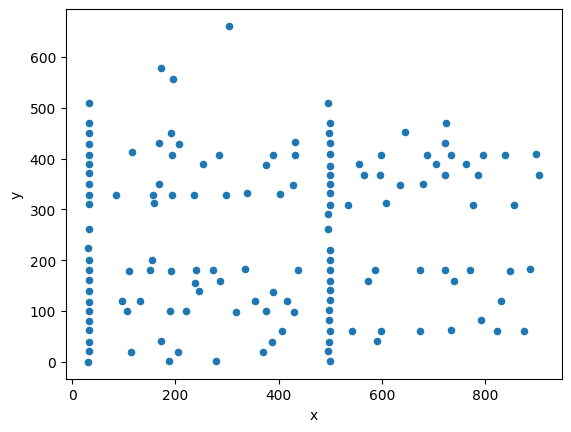

In [28]:
tbl:pd.DataFrame = extract_formated_text_from_image(result, 100, 50)
tbl.plot(kind='scatter', x='x', y='y')

<Axes: xlabel='coluna', ylabel='linha'>

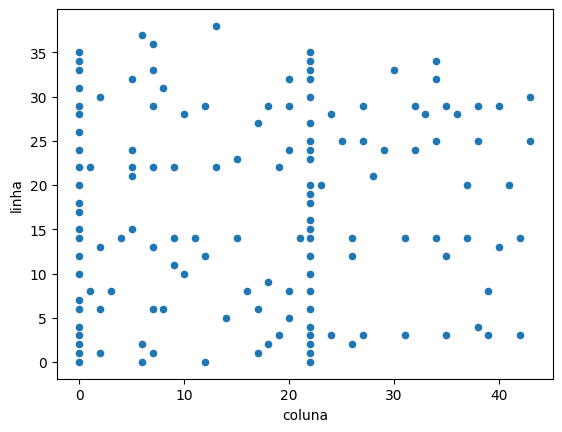

In [29]:
tbl.plot(kind='scatter', x='coluna', y='linha')

In [30]:
tbl[tbl['linha']==0]

,text,x,y,text_size,faixa_y,faixa_x,linha,coluna
135,ipsum dolor sit amet:.',31.0,0.0,23,"(-0.661, 6.61]","(30.126, 48.48]",0,0
136,comes from,187.0,1.0,10,"(-0.661, 6.61]","(170.84, 188.32]",0,6
137,line in section 1.10.32,279.0,2.0,23,"(-0.661, 6.61]","(275.72, 293.2]",0,12
138,"injected humour, or non-characteristic words etc:",499.0,1.0,49,"(-0.661, 6.61]","(485.48, 502.96]",0,22
